In [69]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np 
import pandas as pd 

import os # data processing, CSV file I/O (e.g. pd.read_csv)
import math # linear algebra
import pickle

from itertools import product
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [70]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'item_categories.csv', 'items.csv', 'shops.csv', 'sales_train.csv', 'sample_submission.csv']


We have five data files:

1. train.csv  - item price and number of items sold on each date. 
2. shops.csv - shops corresponding to shop id in train.csv.
3. items.csv - items corresponding to item id in train.csv
4. item_categories.csv - details of item category corresponding to category id in item.csv
5. test.csv - test data for prediction

In [71]:
base_path = "input"
items = pd.read_csv(os.path.join(base_path, 'items.csv'))
item_categories = pd.read_csv(os.path.join(base_path, 'item_categories.csv'))
shops = pd.read_csv(os.path.join(base_path, 'shops.csv'))
train = pd.read_csv(os.path.join(base_path, 'sales_train.csv'))
test = pd.read_csv(os.path.join(base_path, 'test.csv'))

# Exploratory Data Analysis (EDA)

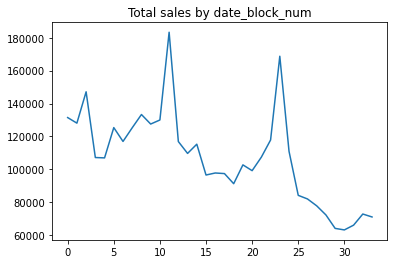

In [72]:
x = train.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
plt.title('Total sales by date_block_num')
plt.plot(x.index, x['item_cnt_day'])

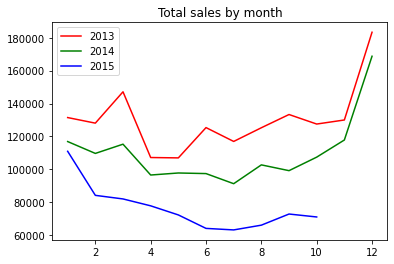

In [73]:
plt.title('Total sales by month')

x_1 = x[x.index < 12]
plt.plot(x_1.index + 1, x_1['item_cnt_day'], color='red', label='2013')

x_2 = x[x.index >= 12]
x_2 = x_2[x_2.index < 24]
plt.plot(range(1, len(x_2.index) + 1), x_2['item_cnt_day'], color='green', label='2014')

x_3 = x[x.index >= 24]
plt.plot(range(1, len(x_3.index) + 1), x_3['item_cnt_day'], color='blue', label='2015')

plt.legend()

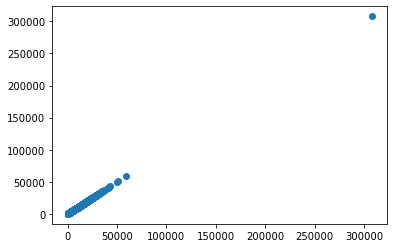

In [74]:
prices = set(train['item_price'].values)
plt.scatter(x=list(prices), y=list(prices))

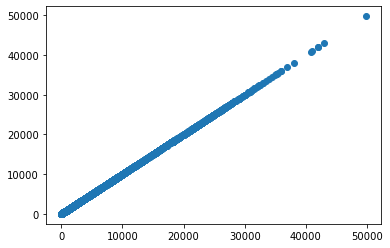

In [75]:
prices = set(train[train['item_price'] < 50000]['item_price'].values)
plt.scatter(x=list(prices), y=list(prices))

Text(0, 0.5, 'item_cnt_day')

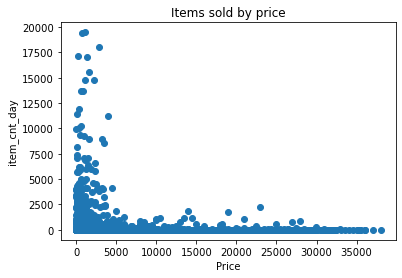

In [76]:
x_price = train[train['item_price'] < 40000] # drop outliers
x_price = x_price.groupby('item_price').agg({'item_cnt_day': 'sum'})
x_price = x_price[x_price['item_cnt_day'].values < 20000] # drop outliers
plt.title('Items sold by price')
plt.scatter(x_price.index, x_price['item_cnt_day'])
plt.xlabel('Price')
plt.ylabel('item_cnt_day')

# Preprocessing and feature engineering

There is quite a bit of pre-processing needed. For example, performing database ops to merge disparate data. Let's begin.

In [77]:
# remove first year of sales
train = train[train['date_block_num'] > 11]

Here we create a grid from all shop-item combinations for every month:

In [78]:
date_blocks = {}

for block in train['date_block_num'].unique():
    d = train[train['date_block_num'] == block]
    shop_ids = sorted(d['shop_id'].unique())
    item_ids = sorted(d['item_id'].unique())
    date_blocks[block] = np.array(list(product(*[shop_ids, item_ids, [block]])), dtype='int32')

Here we put the blocks into single pandas DataFrame:

In [79]:
tuples_df = pd.DataFrame(np.vstack(date_blocks.values()), columns = ['shop_id', 'item_id', 'date_block_num'], dtype=np.int32)

/tmp/ipykernel_21296/3916672955.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  tuples_df = pd.DataFrame(np.vstack(date_blocks.values()), columns = ['shop_id', 'item_id', 'date_block_num'], dtype=np.int32)


Aggregation of values for `(shop_id, item_id, month)` tuples:

In [80]:
data = train.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False).agg({'item_cnt_day': 'sum'})
data = data.rename(columns={'item_cnt_day': 'target_value'})
data.head(10)

,shop_id,item_id,date_block_num,target_value
0,2,27,17,1.0
1,2,30,15,1.0
2,2,30,16,1.0
3,2,31,16,1.0
4,2,31,33,1.0
5,2,32,12,1.0
6,2,32,14,1.0
7,2,32,18,1.0
8,2,32,20,2.0
9,2,32,21,2.0


Merge the `data` with `tuples_df` to get populated grid of data for further processing and feature generation. Fill `Nan`s with `0.0`.

In [81]:
train_data = pd.merge(tuples_df, data, how='left', on=['shop_id', 'item_id', 'date_block_num']).fillna(0)
train_data.head(10)

,shop_id,item_id,date_block_num,target_value
0,2,27,12,0.0
1,2,30,12,0.0
2,2,31,12,0.0
3,2,32,12,1.0
4,2,33,12,1.0
5,2,34,12,0.0
6,2,36,12,0.0
7,2,37,12,0.0
8,2,39,12,0.0
9,2,40,12,0.0


Fix duplicate `shop_id`

In [82]:
train_data.loc[train_data['shop_id'] == 0, 'shop_id'] = 57
train_data.loc[train_data['shop_id'] == 1, 'shop_id'] = 58
train_data.loc[train_data['shop_id'] == 11, 'shop_id'] = 10

Get [lagged](https://ealdrich.github.io/Teaching/Econ211C/LectureNotes/Unit1-ARMA/lagOperators.html) values:

In [83]:
lag_periods = [1, 2, 3, 6, 12]

for lag in lag_periods:
    lag_col_name = 'target_lag_' + str(lag)
    shifted = train_data[['shop_id', 'item_id', 'date_block_num'] + ['target_value']].copy()
    shifted.columns = ['shop_id', 'item_id', 'date_block_num'] + [lag_col_name]
    shifted['date_block_num'] += lag
    train_data = pd.merge(train_data, shifted, on=['shop_id', 'item_id', 'date_block_num'], how='left')
    train_data[lag_col_name].fillna(0, inplace=True)
    
print(train_data[train_data['target_lag_1'] > 0.0].head(50))
train_data.head(50)

        shop_id  item_id  date_block_num  target_value  target_lag_1  \
347348        2       32              13           0.0           1.0   
347349        2       33              13           0.0           1.0   
347375        2       99              13           0.0           1.0   
347435        2      482              13           1.0           2.0   
347437        2      485              13           1.0           1.0   
347509        2      804              13           1.0           1.0   
347525        2      839              13           1.0           1.0   
347590        2     1007              13           0.0           1.0   
347708        2     1406              13           1.0           1.0   
347713        2     1412              13           1.0           1.0   
347714        2     1413              13           0.0           2.0   
347715        2     1414              13           1.0           1.0   
347716        2     1415              13           1.0          

,shop_id,item_id,date_block_num,target_value,target_lag_1,target_lag_2,target_lag_3,target_lag_6,target_lag_12
0,2,27,12,0.0,0.0,0.0,0.0,0.0,0.0
1,2,30,12,0.0,0.0,0.0,0.0,0.0,0.0
2,2,31,12,0.0,0.0,0.0,0.0,0.0,0.0
3,2,32,12,1.0,0.0,0.0,0.0,0.0,0.0
4,2,33,12,1.0,0.0,0.0,0.0,0.0,0.0
5,2,34,12,0.0,0.0,0.0,0.0,0.0,0.0
6,2,36,12,0.0,0.0,0.0,0.0,0.0,0.0
7,2,37,12,0.0,0.0,0.0,0.0,0.0,0.0
8,2,39,12,0.0,0.0,0.0,0.0,0.0,0.0
9,2,40,12,0.0,0.0,0.0,0.0,0.0,0.0


Create year and month indices

In [21]:
train_data['year_idx'] = train_data['date_block_num'] // 12
train_data['month_idx'] = train_data['date_block_num'] % 12 + 1
train_data.head(10)

,shop_id,item_id,date_block_num,target_value,target_lag_1,target_lag_2,target_lag_3,target_lag_6,target_lag_12,year_idx,month_idx
0,2,27,12,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,2,30,12,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2,2,31,12,0.0,0.0,0.0,0.0,0.0,0.0,1,1
3,2,32,12,1.0,0.0,0.0,0.0,0.0,0.0,1,1
4,2,33,12,1.0,0.0,0.0,0.0,0.0,0.0,1,1
5,2,34,12,0.0,0.0,0.0,0.0,0.0,0.0,1,1
6,2,36,12,0.0,0.0,0.0,0.0,0.0,0.0,1,1
7,2,37,12,0.0,0.0,0.0,0.0,0.0,0.0,1,1
8,2,39,12,0.0,0.0,0.0,0.0,0.0,0.0,1,1
9,2,40,12,0.0,0.0,0.0,0.0,0.0,0.0,1,1


Map days in month to create day indices

In [22]:
num_days = pd.Series([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
train_data['days_in_month'] = train_data['month_idx'].map(num_days)
train_data.head(10)

,shop_id,item_id,date_block_num,target_value,target_lag_1,target_lag_2,target_lag_3,target_lag_6,target_lag_12,year_idx,month_idx,days_in_month
0,2,27,12,0.0,0.0,0.0,0.0,0.0,0.0,1,1,31
1,2,30,12,0.0,0.0,0.0,0.0,0.0,0.0,1,1,31
2,2,31,12,0.0,0.0,0.0,0.0,0.0,0.0,1,1,31
3,2,32,12,1.0,0.0,0.0,0.0,0.0,0.0,1,1,31
4,2,33,12,1.0,0.0,0.0,0.0,0.0,0.0,1,1,31
5,2,34,12,0.0,0.0,0.0,0.0,0.0,0.0,1,1,31
6,2,36,12,0.0,0.0,0.0,0.0,0.0,0.0,1,1,31
7,2,37,12,0.0,0.0,0.0,0.0,0.0,0.0,1,1,31
8,2,39,12,0.0,0.0,0.0,0.0,0.0,0.0,1,1,31
9,2,40,12,0.0,0.0,0.0,0.0,0.0,0.0,1,1,31


Now there is a need to add `item_category_id` and expand mean encoding sales by `item_id`, `shop_id` and `item_category_id`

In [23]:
# Add item_category_id
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
train_data = pd.merge(train_data, item_category_mapping, how='left', on='item_id')

# Expand mean encoding sales by item_id
cumsum = train_data.groupby('item_id')['target_value'].cumsum() - train_data['target_value']
cumcnt = train_data.groupby('item_id')['target_value'].cumcount()
train_data['item_target_enc_exp'] = cumsum / cumcnt

target_mean = train_data['target_value'].mean()
train_data['item_target_enc_exp'].fillna(target_mean, inplace=True)

In [25]:
# Expand mean encoding sales by shop_id
cumsum = train_data.groupby('shop_id')['target_value'].cumsum() - train_data['target_value']
cumcnt = train_data.groupby('shop_id')['target_value'].cumcount()
train_data['shop_target_enc_exp'] = cumsum / cumcnt

target_mean = train_data['target_value'].mean()
train_data['shop_target_enc_exp'].fillna(target_mean, inplace=True)

In [26]:
# Expand mean encoding sales by item_category_id
cumsum = train_data.groupby('item_category_id')['target_value'].cumsum() - train_data['target_value']
cumcnt = train_data.groupby('item_category_id')['target_value'].cumcount()
train_data['item_category_target_enc_exp'] = cumsum / cumcnt

target_mean = train_data['target_value'].mean()
train_data['item_category_target_enc_exp'].fillna(target_mean, inplace=True)

In [27]:
# Add last sale for shop_id, item_id pairs
last_sale_df = []
for d in range(1, 35):
    df = train_data[train_data.date_block_num < d].groupby(['shop_id', 'item_id'], as_index=False)['date_block_num'].max()
    df['last_sale_ago'] = d - df.date_block_num
    df.date_block_num = d
    last_sale_df.append(df)
last_sale_df = pd.concat(last_sale_df)

train_data = pd.merge(train_data, last_sale_df, on=['shop_id', 'item_id', 'date_block_num'], how='left')
train_data['last_sale_ago'].fillna(0, inplace=True)

In [28]:
# Add last shop sale
last_shop_sale_df = []
for d in range(1, 35):
    df = train_data[train_data.date_block_num < d].groupby('shop_id', as_index=False)['date_block_num'].max()
    df['last_shop_sale_ago'] = d - df.date_block_num
    df.date_block_num = d
    last_shop_sale_df.append(df)
last_shop_sale_df = pd.concat(last_shop_sale_df)

train_data = pd.merge(train_data, last_shop_sale_df, on=['shop_id', 'date_block_num'], how='left')
train_data['last_shop_sale_ago'].fillna(0, inplace=True)

In [29]:
# Add last item sale
last_item_sale_df = []
for d in range(1, 35):
    df = train_data[train_data.date_block_num < d].groupby('item_id', as_index=False)['date_block_num'].max()
    df['last_item_sale_ago'] = d - df.date_block_num
    df.date_block_num = d
    last_item_sale_df.append(df)
last_item_sale_df = pd.concat(last_item_sale_df)

train_data = pd.merge(train_data, last_item_sale_df, on=['item_id', 'date_block_num'], how='left')
train_data['last_item_sale_ago'].fillna(0, inplace=True)

In [30]:
# Remove `date_block_num` feature
train_data = train_data.drop(columns='date_block_num')

In [31]:
# One-hot encoding for linear models
year_oh = pd.get_dummies(train_data['year_idx'], prefix='year')
month_oh = pd.get_dummies(train_data['month_idx'], prefix='month')
train_data_oh = train_data.drop(columns=['shop_id', 'item_id', 'item_category_id', 'year_idx', 'month_idx', 'target_value'])
train_data_oh = pd.concat([train_data_oh, year_oh, month_oh], axis=1)
train_data_oh.head()

,target_lag_1,target_lag_2,target_lag_3,target_lag_6,target_lag_12,days_in_month,item_target_enc_exp,shop_target_enc_exp,item_category_target_enc_exp,last_sale_ago,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0.0,0.0,0.0,0.0,0.0,31,0.324582,0.324582,0.324582,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,31,0.324582,0.000000,0.324582,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,31,0.324582,0.000000,0.324582,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,31,0.324582,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,31,0.324582,0.250000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0


# Train/Validation split

On this occasion, we split the data by time.

In [32]:
train_b_index = (train_data['year_idx'] == 2) & (train_data['month_idx'] == 9)
train_c_index = (train_data['year_idx'] == 2) & (train_data['month_idx'] == 10)
train_a_index = ~train_b_index & ~train_c_index

X_train_a = train_data[train_a_index]
y_train_a = X_train_a['target_value'].clip(0, 20)
X_train_a = X_train_a.drop(columns='target_value')

X_train_b = train_data[train_b_index]
y_train_b = X_train_b['target_value'].clip(0, 20)
X_train_b = X_train_b.drop(columns='target_value')

X_train_c = train_data[train_c_index]
y_train_c = X_train_c['target_value'].clip(0, 20)
X_train_c = X_train_c.drop(columns='target_value')

Do the split for linear models as well

In [33]:
# split for linear models
X_train_a_oh = train_data_oh[train_a_index]
X_train_b_oh = train_data_oh[train_b_index]
X_train_c_oh = train_data_oh[train_c_index]

# Train

Train first group of models on `X_train_a`. We will compare the output from three models, XGBoost, an ANN model and Random Forest Regressor.

In [34]:
# XGB
XGBmodel = xgb.XGBRegressor(max_depth=4, 
                            learning_rate=0.5, 
                            n_jobs=-1)
XGBmodel.fit(X_train_a, y_train_a)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [35]:
# MLP
MLPmodel = MLPRegressor(hidden_layer_sizes=(100, 100), 
                        activation='relu', 
                        learning_rate_init=0.01, 
                        max_iter=10, 
                        shuffle=False, verbose=True)
MLPmodel.fit(X_train_a_oh.values, y_train_a)

Iteration 1, loss = 0.41444212
Iteration 2, loss = 0.36054599
Iteration 3, loss = 0.35751834
Iteration 4, loss = 0.35519630
Iteration 5, loss = 0.35562545
Iteration 6, loss = 0.35658813
Iteration 7, loss = 0.36336121
Iteration 8, loss = 0.37871711
Iteration 9, loss = 0.40960707
Iteration 10, loss = 0.39560791


/home/taylorc/anaconda3/envs/coursera-advanced-ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(100, 100), learning_rate_init=0.01,
             max_iter=10, shuffle=False, verbose=True)

In [36]:
# RFRegressor
RFRmodel = RandomForestRegressor(n_estimators=10, 
                                 criterion='mse', 
                                 max_depth=None, 
                                 n_jobs=-1, verbose=1)
RFRmodel.fit(X_train_a.values, y_train_a)

/home/taylorc/anaconda3/envs/coursera-advanced-ml/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  2.7min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.1min finished


RandomForestRegressor(criterion='mse', n_estimators=10, n_jobs=-1, verbose=1)

## Stacking

In [37]:
# XGB
y_pred_1 = XGBmodel.predict(X_train_b)
rmse = math.sqrt(mean_squared_error(y_train_b, y_pred_1))
R_score = r2_score(y_train_b, y_pred_1)
print('XGBoost rmse: ' + str(rmse) + ', R2: ' + str(R_score))

XGBoost rmse: 0.8063716450577464, R2: 0.5119059503638379


In [38]:
# MLP
y_pred_2 = MLPmodel.predict(X_train_b_oh)
rmse = math.sqrt(mean_squared_error(y_train_b, y_pred_2))
R_score = r2_score(y_train_b, y_pred_2)
print('MLP rmse: ' + str(rmse) + ', R2: ' + str(R_score))

/home/taylorc/anaconda3/envs/coursera-advanced-ml/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


MLP rmse: 0.937665067637553, R2: 0.34002347098277985


In [39]:
# Random forest baseline model
y_pred_3 = RFRmodel.predict(X_train_b)
rmse = math.sqrt(mean_squared_error(y_train_b, y_pred_3))
R_score = r2_score(y_train_b, y_pred_3)
print('Random forest rmse: ' + str(rmse) + ', R2: ' + str(R_score))

/home/taylorc/anaconda3/envs/coursera-advanced-ml/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s


Random forest rmse: 0.8188143160280831, R2: 0.4967267219491034


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


## Second level model (linear regression)

In [40]:
# Level 2 model
X_train_b_2 = np.stack([y_pred_1, y_pred_2, y_pred_3], axis=-1)
model = LinearRegression(n_jobs=-1)
model.fit(X_train_b_2, y_train_b)

LinearRegression(n_jobs=-1)

In [41]:
# Evaluate on train_c
y_pred_1 = XGBmodel.predict(X_train_c)
y_pred_2 = MLPmodel.predict(X_train_c_oh)
y_pred_3 = RFRmodel.predict(X_train_c)
X_train_c_2 = np.stack([y_pred_1, y_pred_2, y_pred_3], axis=-1)

stack_pred = model.predict(X_train_c_2)
rmse = math.sqrt(mean_squared_error(y_train_c, stack_pred))
R_score = r2_score(y_train_c, y_pred_1)
print('Ensemble rmse: ' + str(rmse) + ', R2: ' + str(R_score))

/home/taylorc/anaconda3/envs/coursera-advanced-ml/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
/home/taylorc/anaconda3/envs/coursera-advanced-ml/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Ensemble rmse: 0.8485272117911536, R2: 0.4339526401687227


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.3s finished


Train second level model on `X_train_b` and `X_train_c` (i.e. monthly splits from before)

In [42]:
X_train_bc_2 = np.concatenate([X_train_b_2, X_train_c_2], axis=0)
y_train_bc = np.concatenate([y_train_b, y_train_c], axis=0)

# train model level 2
model.fit(X_train_bc_2, y_train_bc)

LinearRegression(n_jobs=-1)

Now, finally, here we will actually make predictions:

In [43]:
test_data = pd.read_csv(os.path.join(base_path, 'test.csv'))

test_data.loc[test_data['shop_id'] == 0, 'shop_id'] = 57
test_data.loc[test_data['shop_id'] == 1, 'shop_id'] = 58
test_data.loc[test_data['shop_id'] == 11, 'shop_id'] = 10

# Generate lag features
test_data['date_block_num'] = 34
lags = [1, 2, 3, 6, 12]
train_data['date_block_num'] = train_data['year_idx'] * 12 + train_data['month_idx'] - 1

for lag in lags:
    lag_col_name = 'target_lag_' + str(lag)
    shifted = train_data[['shop_id', 'item_id', 'date_block_num'] + ['target_value']].copy()
    shifted.columns = ['shop_id', 'item_id', 'date_block_num'] + [lag_col_name]
    shifted['date_block_num'] += lag
    test_data = pd.merge(test_data, shifted, on=['shop_id', 'item_id', 'date_block_num'], how='left')
    test_data[lag_col_name].fillna(0, inplace=True)

# Add year index and month
test_data['year_idx'] = 2
test_data['month_idx'] = 11

# Add days in month
test_data['days_in_month'] = 30

# add item_category_id
test_data = pd.merge(test_data, item_category_mapping, how='left', on='item_id')

# Add expanding mean encoding for item_id
item_id_mean = train_data.groupby('item_id')['target_value'].mean()
test_data['item_target_enc_exp'] = test_data['item_id'].map(item_id_mean)
test_data['item_target_enc_exp'].fillna(target_mean, inplace=True)

# Add expanding mean encoding for shop_id
shop_id_mean = train_data.groupby('shop_id')['target_value'].mean()
test_data['shop_target_enc_exp'] = test_data['shop_id'].map(shop_id_mean)
test_data['shop_target_enc_exp'].fillna(target_mean, inplace=True)

# Add expanding mean encoding for item_id
item_id_mean = train_data.groupby('item_category_id')['target_value'].mean()
test_data['item_category_target_enc_exp'] = test_data['item_category_id'].map(item_id_mean)
test_data['item_category_target_enc_exp'].fillna(target_mean, inplace=True)

# Add last sale ago for shop_id, item_id pairs
test_data = pd.merge(test_data, last_sale_df, on=['shop_id', 'item_id', 'date_block_num'], how='left')
test_data['last_sale_ago'].fillna(0, inplace=True)

# Add last shop sale
test_data = pd.merge(test_data, last_shop_sale_df, on=['shop_id', 'date_block_num'], how='left')
test_data['last_shop_sale_ago'].fillna(0, inplace=True)

# Add last item sale
test_data = pd.merge(test_data, last_item_sale_df, on=['item_id', 'date_block_num'], how='left')
test_data['last_item_sale_ago'].fillna(0, inplace=True)

# Drop id column
test_data.drop(columns='ID', inplace=True)

# Drop date_block_num
test_data.drop(columns='date_block_num', inplace=True)

test_data.head()

,shop_id,item_id,target_lag_1,target_lag_2,target_lag_3,target_lag_6,target_lag_12,year_idx,month_idx,days_in_month,item_category_id,item_target_enc_exp,shop_target_enc_exp,item_category_target_enc_exp,last_sale_ago,last_shop_sale_ago,last_item_sale_ago
0,5,5037,0.0,1.0,3.0,1.0,1.0,2,11,30,19,1.950845,0.207204,0.600482,1.0,1,1.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,2,11,30,55,0.324582,0.207204,0.224931,0.0,1,0.0
2,5,5233,1.0,3.0,1.0,3.0,0.0,2,11,30,19,1.656863,0.207204,0.600482,1.0,1,1.0
3,5,5232,0.0,0.0,1.0,0.0,0.0,2,11,30,23,1.093023,0.207204,0.610830,1.0,1,1.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,2,11,30,20,0.324582,0.207204,1.837239,0.0,1,0.0


In [45]:
test_data_oh = test_data.drop(columns=['shop_id', 'item_id', 'item_category_id', 'year_idx', 'month_idx'])
for year in range(1,3):
    test_data_oh['year_' + str(year)] = int(year == 2)
for month in range(1, 13):
    test_data_oh['month_' + str(month)] = int(month == 11)
test_data_oh.head()

,target_lag_1,target_lag_2,target_lag_3,target_lag_6,target_lag_12,days_in_month,item_target_enc_exp,shop_target_enc_exp,item_category_target_enc_exp,last_sale_ago,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0.0,1.0,3.0,1.0,1.0,30,1.950845,0.207204,0.600482,1.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,0.0,0.0,0.0,0.0,30,0.324582,0.207204,0.224931,0.0,...,0,0,0,0,0,0,0,0,1,0
2,1.0,3.0,1.0,3.0,0.0,30,1.656863,0.207204,0.600482,1.0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,0.0,1.0,0.0,0.0,30,1.093023,0.207204,0.610830,1.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,0.0,0.0,0.0,0.0,30,0.324582,0.207204,1.837239,0.0,...,0,0,0,0,0,0,0,0,1,0


In [49]:
XGB_output = XGBmodel.predict(test_data)
mlp_output = MLPmodel.predict(test_data_oh)
rf_output = RFRmodel.predict(test_data)

X_test_2 = np.stack([XGB_output, mlp_output, rf_output], axis=-1)
predictions = model.predict(X_test_2)

df_pred = pd.DataFrame({'item_cnt_month': predictions})
df_pred.to_csv('submission.csv', index_label='ID')

# save the models to a serialisable format
XGB_pkl = 'XGB_model.pkl'
pickle.dump(XGBmodel, open(XGB_pkl, 'wb'))

MLP_pkl = 'MLPmodel.pkl'
pickle.dump(MLPmodel, open(MLP_pkl, 'wb'))

RFR_pkl = 'RFRmodel.pkl'
pickle.dump(RFRmodel, open(RFR_pkl, 'wb'))

/home/taylorc/anaconda3/envs/coursera-advanced-ml/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
/home/taylorc/anaconda3/envs/coursera-advanced-ml/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.3s finished


<a href="submission.csv"> Download File </a>